In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
import contextily as ctx

from asp_plot.jitter import read_linescan_csm_cam, read_angles

In [2]:
before1 = "../tests/test_data/jitter/csm-10300100A0D00200.r100.adjusted_state.json"
before2 = "../tests/test_data/jitter/csm-10300100A15E3900.r100.adjusted_state.json"
after1 = "../tests/test_data/jitter/jitter_solved_csm-10300100A0D00200.r100.adjusted_state.json"
after2 = "../tests/test_data/jitter/jitter_solved_csm-10300100A15E3900.r100.adjusted_state.json"

# ba
before3 = "../tests/test_data/ba_cams/1040010075633C00.json"
after3 = "../tests/test_data/ba_cams/1040010075633C00.adjusted_state.json"
before4 = "../tests/test_data/ba_cams/1040010074793300.json"
after4 = "../tests/test_data/ba_cams/1040010074793300.adjusted_state.json"

# map_crs = "32728" # UTM 28S
map_crs = "32603" # UTM 3N
# map_crs = "4326"

ctx_kwargs = {
    "crs": f"EPSG:{map_crs}",
    "source": ctx.providers.Esri.WorldImagery,
    "attribution_size": 0,
    "alpha": 0.5,
}

In [3]:
# cam1, cam2 = before1, after1
# cam1, cam2 = before2, after2
# cam1, cam2 = before3, after3
cam1, cam2 = before4, after4

positions1, rotations1 = read_linescan_csm_cam(cam1)
positions2, rotations2 = read_linescan_csm_cam(cam2)

positions1 = np.array(positions1)
positions2 = np.array(positions2)
rotations1 = np.array(rotations1)
rotations2 = np.array(rotations2)

orig_rotation_angles, opt_rotation_angles = read_angles([cam1], [cam2], [])

orig_roll  = [r[0] for r in orig_rotation_angles]
orig_pitch = [r[1] for r in orig_rotation_angles]
orig_yaw   = [r[2] for r in orig_rotation_angles]
opt_roll   = [r[0] for r in opt_rotation_angles]
opt_pitch  = [r[1] for r in opt_rotation_angles]
opt_yaw    = [r[2] for r in opt_rotation_angles]

roll_diff = np.array(orig_roll) - np.array(opt_roll)
pitch_diff = np.array(orig_pitch) - np.array(opt_pitch)
yaw_diff = np.array(orig_yaw) - np.array(opt_yaw)

In [4]:
def reproject_ecef(positions, to_epsg=4326):
    transformer = Transformer.from_crs("EPSG:4978", f"EPSG:{to_epsg}")
    x, y, z = transformer.transform(positions[:, 0], positions[:, 1], positions[:, 2])
    return np.column_stack((x, y, z))

In [5]:
positions1_proj = reproject_ecef(positions1, to_epsg=map_crs)
positions2_proj = reproject_ecef(positions2, to_epsg=map_crs)

position_diffs = positions2_proj - positions1_proj
x_diff = position_diffs[:, 0]
y_diff = position_diffs[:, 1]
z_diff = position_diffs[:, 2]
position_diff_magnitudes = np.linalg.norm(position_diffs, axis=1)

data = {
    'position1': [Point(x, y, z) for x, y, z in positions1_proj],
    'position2': [Point(x, y, z) for x, y, z in positions2_proj],
    'rotation1': [r for r in rotations1],
    'rotation2': [r for r in rotations2],
    'position_diff_magnitude': position_diff_magnitudes,
    'x_diff': x_diff,
    'y_diff': y_diff,
    'z_diff': z_diff,
    'roll_diff': roll_diff,
    'pitch_diff': pitch_diff,
    'yaw_diff': yaw_diff,
}

df = pd.DataFrame(data)

gdf = gpd.GeoDataFrame(df, geometry='position1')

gdf.set_crs(epsg=map_crs, inplace=True)


,position1,position2,rotation1,rotation2,position_diff_magnitude,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff
0,POINT Z (762643.518 8244622.032 625479.036),POINT Z (762645.3978834332 8244621.634096889 6...,"[[0.39876128978812075, -0.915316617246715, -0....","[[0.39874497225854727, -0.9153237660074273, -0...",1.949295,1.880202,-0.398100,0.325743,-0.000310,1.251976e-10,5.167067e-11
1,POINT Z (762590.513 8244493.598 625478.899),POINT Z (762592.3909003583 8244493.201179318 6...,"[[0.39873277503302407, -0.9153313286400376, -0...","[[0.398716457151586, -0.9153384767804489, -0.0...",1.946948,1.878050,-0.397206,0.325214,-0.000310,1.499814e-10,1.853095e-11
2,POINT Z (762537.508 8244365.165 625478.761),POINT Z (762539.3834614446 8244364.768480699 6...,"[[0.39870424020061007, -0.915346045594414, -0....","[[0.39868792196745767, -0.9153531931142268, -0...",1.944602,1.875898,-0.396313,0.324685,-0.000310,1.300293e-11,-1.168132e-11
3,POINT Z (762484.502 8244236.731 625478.624),POINT Z (762486.3755760472 8244236.336024694 6...,"[[0.39867568528366765, -0.9153607681112091, -0...","[[0.3986593666989507, -0.9153679150101263, -0....",1.942256,1.873746,-0.395419,0.324156,-0.000310,-1.348432e-10,-8.839152e-12
4,POINT Z (762431.496 8244108.298 625478.487),POINT Z (762433.3672754645 8244107.903890629 6...,"[[0.3986471103571662, -0.915375496156118, -0.0...","[[0.39863079142103475, -0.915382642433843, -0....",1.939909,1.871594,-0.394525,0.323627,-0.000310,7.155165e-11,2.378897e-11
...,...,...,...,...,...,...,...,...,...,...,...
1309,POINT Z (692881.793 8076693.39 625285.079),POINT Z (692880.8696549945 8076694.155743411 6...,"[[0.345385985438331, -0.9382967670633773, -0.0...","[[0.3453693447122172, -0.9383028558691037, -0....",1.254931,-0.923202,0.765850,-0.368814,-0.000309,1.634284e-10,-2.356160e-11
1310,POINT Z (692828.215 8076565.244 625284.92),POINT Z (692827.2900315337 8076566.0102456 625...,"[[0.34533415229948494, -0.9383162374628937, -0...","[[0.34531751144062844, -0.9383223252790056, -0...",1.257195,-0.925334,0.766734,-0.369347,-0.000309,1.554028e-10,-3.575451e-11
1311,POINT Z (692774.637 8076437.097 625284.761),POINT Z (692773.7099960432 8076437.864986017 6...,"[[0.3452823037525115, -0.938335709508801, -0.0...","[[0.3452656627610967, -0.9383417963350302, -0....",1.259460,-0.927465,0.767618,-0.369879,-0.000309,-1.734417e-10,2.356160e-11
1312,POINT Z (692721.059 8076308.951 625284.602),POINT Z (692720.1295245009 8076309.719904139 6...,"[[0.34523043986743873, -0.938355183174179, -0....","[[0.3452137987436501, -0.9383612690102575, -0....",1.261725,-0.929596,0.768503,-0.370411,-0.000309,-1.666489e-10,5.195488e-11


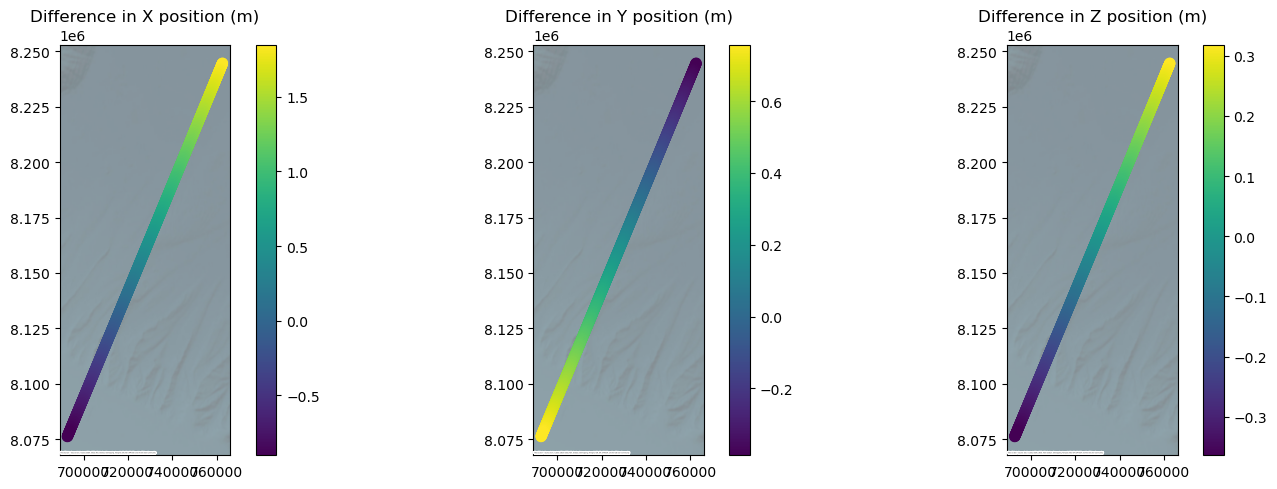

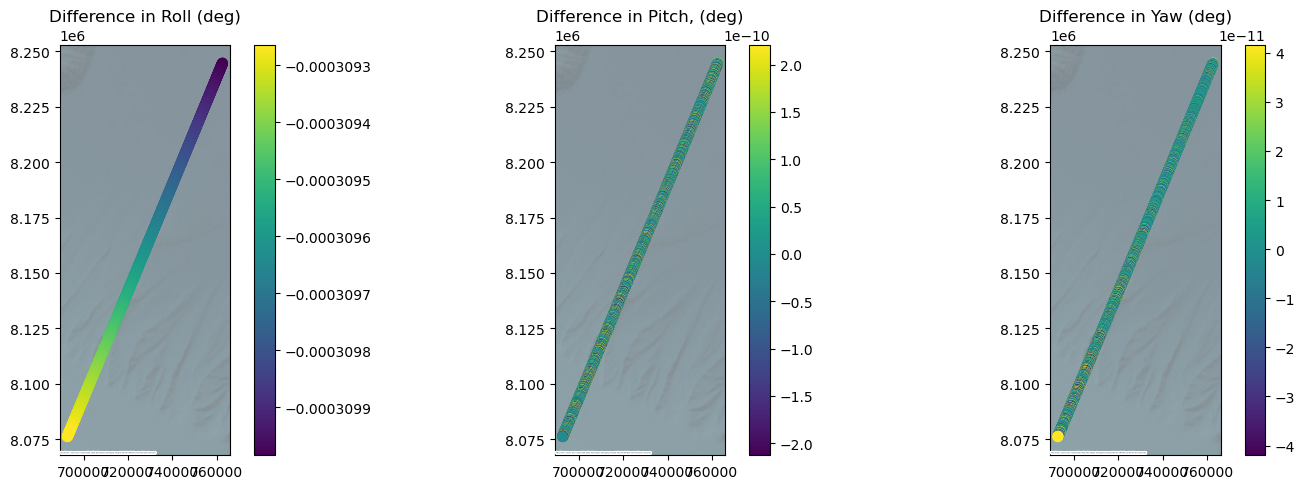

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gdf.plot(column='x_diff', cmap='viridis', markersize=50, legend=True, ax=axes[0], vmin=np.percentile(x_diff, 1), vmax=np.percentile(x_diff, 99))
axes[0].set_title('Difference in X position (m)')
ctx.add_basemap(ax=axes[0], **ctx_kwargs)

gdf.plot(column='y_diff', cmap='viridis', markersize=50, legend=True, ax=axes[1], vmin=np.percentile(y_diff, 1), vmax=np.percentile(y_diff, 99))
axes[1].set_title('Difference in Y position (m)')
ctx.add_basemap(ax=axes[1], **ctx_kwargs)

gdf.plot(column='z_diff', cmap='viridis', markersize=50, legend=True, ax=axes[2], vmin=np.percentile(z_diff, 1), vmax=np.percentile(z_diff, 99))
axes[2].set_title('Difference in Z position (m)')
ctx.add_basemap(ax=axes[2], **ctx_kwargs)

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gdf.plot(column='roll_diff', cmap='viridis', markersize=50, legend=True, ax=axes[0], vmin=np.percentile(roll_diff, 1), vmax=np.percentile(roll_diff, 99))
axes[0].set_title('Difference in Roll (deg)')
ctx.add_basemap(ax=axes[0], **ctx_kwargs)

gdf.plot(column='pitch_diff', cmap='viridis', markersize=50, legend=True, ax=axes[1], vmin=np.percentile(pitch_diff, 1), vmax=np.percentile(pitch_diff, 99))
axes[1].set_title('Difference in Pitch, (deg)')
ctx.add_basemap(ax=axes[1], **ctx_kwargs)

gdf.plot(column='yaw_diff', cmap='viridis', markersize=50, legend=True, ax=axes[2], vmin=np.percentile(yaw_diff, 1), vmax=np.percentile(yaw_diff, 99))
axes[2].set_title('Difference in Yaw (deg)')
ctx.add_basemap(ax=axes[2], **ctx_kwargs)

plt.tight_layout()
plt.show()

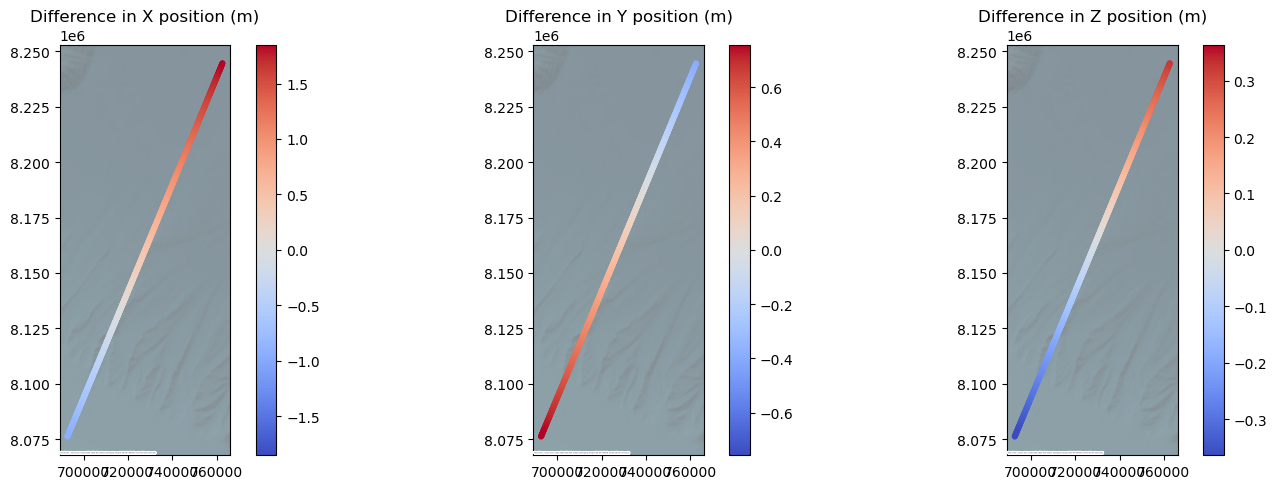

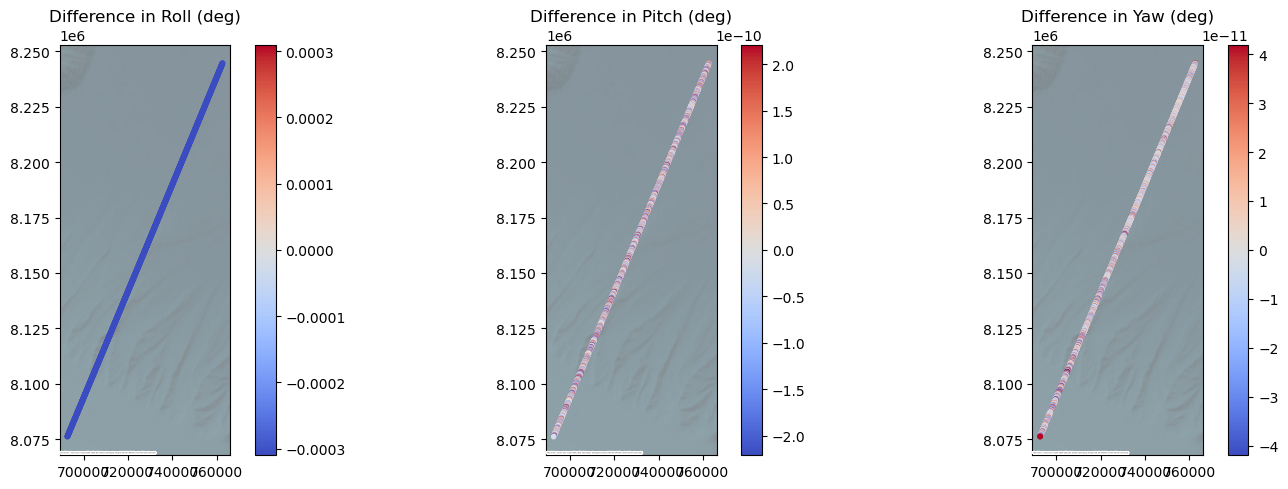

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the symmetric vmin and vmax for centering around 0
x_vmax = max(abs(np.percentile(x_diff, 1)), abs(np.percentile(x_diff, 99)))
y_vmax = max(abs(np.percentile(y_diff, 1)), abs(np.percentile(y_diff, 99)))
z_vmax = max(abs(np.percentile(z_diff, 1)), abs(np.percentile(z_diff, 99)))

gdf.plot(column='x_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[0], vmin=-x_vmax, vmax=x_vmax)
axes[0].set_title('Difference in X position (m)')
ctx.add_basemap(ax=axes[0], **ctx_kwargs)

gdf.plot(column='y_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[1], vmin=-y_vmax, vmax=y_vmax)
axes[1].set_title('Difference in Y position (m)')
ctx.add_basemap(ax=axes[1], **ctx_kwargs)

gdf.plot(column='z_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[2], vmin=-z_vmax, vmax=z_vmax)
axes[2].set_title('Difference in Z position (m)')
ctx.add_basemap(ax=axes[2], **ctx_kwargs)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the symmetric vmin and vmax for centering around 0
roll_vmax = max(abs(np.percentile(roll_diff, 1)), abs(np.percentile(roll_diff, 99)))
pitch_vmax = max(abs(np.percentile(pitch_diff, 1)), abs(np.percentile(pitch_diff, 99)))
yaw_vmax = max(abs(np.percentile(yaw_diff, 1)), abs(np.percentile(yaw_diff, 99)))

gdf.plot(column='roll_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[0], vmin=-roll_vmax, vmax=roll_vmax)
axes[0].set_title('Difference in Roll (deg)')
ctx.add_basemap(ax=axes[0], **ctx_kwargs)

gdf.plot(column='pitch_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[1], vmin=-pitch_vmax, vmax=pitch_vmax)
axes[1].set_title('Difference in Pitch (deg)')
ctx.add_basemap(ax=axes[1], **ctx_kwargs)

gdf.plot(column='yaw_diff', cmap='coolwarm', markersize=10, legend=True, ax=axes[2], vmin=-yaw_vmax, vmax=yaw_vmax)
axes[2].set_title('Difference in Yaw (deg)')
ctx.add_basemap(ax=axes[2], **ctx_kwargs)

plt.tight_layout()
plt.show()

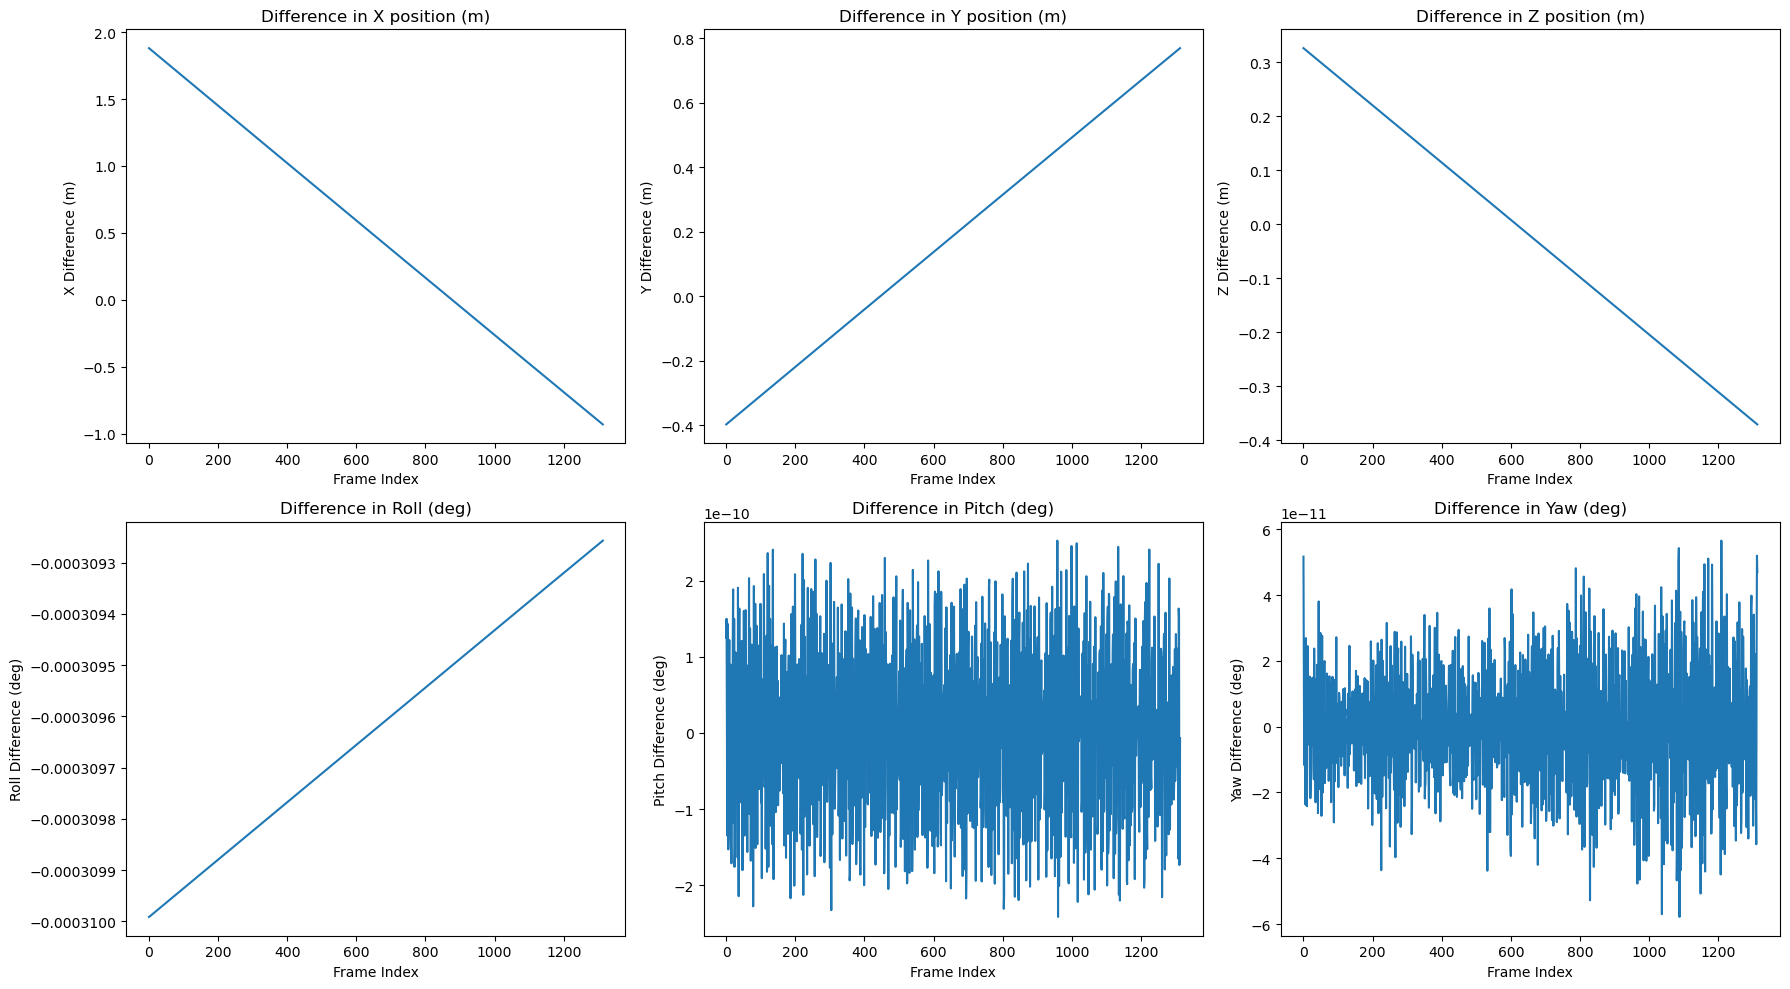

In [8]:
frame = np.arange(gdf.shape[0])

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot differences in x, y, z
axes[0, 0].plot(frame, gdf["x_diff"])
axes[0, 0].set_title('Difference in X position (m)')
axes[0, 0].set_xlabel('Frame Index')
axes[0, 0].set_ylabel('X Difference (m)')

axes[0, 1].plot(frame, gdf["y_diff"])
axes[0, 1].set_title('Difference in Y position (m)')
axes[0, 1].set_xlabel('Frame Index')
axes[0, 1].set_ylabel('Y Difference (m)')

axes[0, 2].plot(frame, gdf["z_diff"])
axes[0, 2].set_title('Difference in Z position (m)')
axes[0, 2].set_xlabel('Frame Index')
axes[0, 2].set_ylabel('Z Difference (m)')

# Plot differences in roll, pitch, yaw
axes[1, 0].plot(frame, gdf["roll_diff"])
axes[1, 0].set_title('Difference in Roll (deg)')
axes[1, 0].set_xlabel('Frame Index')
axes[1, 0].set_ylabel('Roll Difference (deg)')

axes[1, 1].plot(frame, gdf["pitch_diff"])
axes[1, 1].set_title('Difference in Pitch (deg)')
axes[1, 1].set_xlabel('Frame Index')
axes[1, 1].set_ylabel('Pitch Difference (deg)')

axes[1, 2].plot(frame, gdf["yaw_diff"])
axes[1, 2].set_title('Difference in Yaw (deg)')
axes[1, 2].set_xlabel('Frame Index')
axes[1, 2].set_ylabel('Yaw Difference (deg)')

plt.tight_layout()
plt.show()